In [1]:
import pandas as pd

In [2]:
fp = "v3_ad.xls"


In [3]:

df = pd.read_excel(fp)
df = df.drop(["Closing Balance"], axis = 1)


In [4]:

# max min scale the Withdrawal Amt. and Deposit Amt. columns
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[["Withdrawal Amt.", "Deposit Amt."]] = scaler.fit_transform(df[["Withdrawal Amt.", "Deposit Amt."]])


In [6]:

odf = df

In [7]:
# keep only the left part of @ from narration
odf["Narration"] = odf["Narration"].str.split("@").str[0]

# 228 mk

In [8]:
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
from sec_key import secret_key 

def encrypt_text(text, key):
    """
    Encrypts the given text using AES encryption with the specified key.

    Args:
        text (str): The input text to be encrypted.
        key (bytes): The secret key used for encryption.

    Returns:
        bytes: The encrypted text.
    """
    # Create a cipher object
    cipher = AES.new(key, AES.MODE_ECB)

    # Pad the text to be a multiple of 16 bytes
    padded_text = pad(text.encode('utf-8'), AES.block_size)

    # Encrypt the padded text
    encrypted_text = cipher.encrypt(padded_text)

    return encrypted_text

In [9]:
def decrypt_text(encrypted_text, key):
    """
    Decrypts the given encrypted text using AES decryption with the specified key.

    Args:
        encrypted_text (bytes): The encrypted text to be decrypted.
        key (bytes): The secret key used for decryption.

    Returns:
        str: The decrypted text.
    """
    # Create a cipher object
    cipher = AES.new(key, AES.MODE_ECB)

    # Decrypt the encrypted text
    decrypted_padded_text = cipher.decrypt(encrypted_text)

    # Remove the padding from the decrypted text
    decrypted_text = unpad(decrypted_padded_text, AES.block_size)

    return decrypted_text.decode('utf-8')

In [10]:
# encrypt narration column
odf["Narration"] = odf["Narration"].apply(lambda x: encrypt_text(x, secret_key))
odf.head()

,Date,Narration,Chq./Ref.No.,Value Dt,Withdrawal Amt.,Deposit Amt.
0,01/04/22,b'\xae\xf71-\xa6u\xfe\xe4\x1a\xbf\xf9\xd0\xec\...,0000209183559769,01/04/22,0.008713,NaN
1,01/04/22,b'\xc4\xd1c\xca\x9a`\xb7-\xcb\xe6+\xe9h\xfan\x...,0000209192388206,01/04/22,0.008428,NaN
2,01/04/22,"b'\rf)"".\x00""\x80Tn\xe9\xac\x1e""8\x8c\xb0\x13\...",0000209193456839,01/04/22,0.056279,NaN
3,01/04/22,"b'\rf)"".\x00""\x80Tn\xe9\xac\x1e""8\x8c\xb0\x13\...",0000209193525236,01/04/22,0.010384,NaN
4,02/04/22,"b""\xd9\xe2M\xe5\x9f\x18\xcd\x98\xbf!\xc1\xdb\x...",0000209200514102,02/04/22,0.008694,NaN


In [12]:
tk = ["Date", "Withdrawal Amt.", "Deposit Amt."]
df = df[tk]

In [13]:
df.head()

,Date,Withdrawal Amt.,Deposit Amt.
0,01/04/22,0.008713,NaN
1,01/04/22,0.008428,NaN
2,01/04/22,0.056279,NaN
3,01/04/22,0.010384,NaN
4,02/04/22,0.008694,NaN


In [14]:
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%y")
df["Withdrawal Amt."] = pd.to_numeric(df["Withdrawal Amt."], errors="coerce")
df["Deposit Amt."] = pd.to_numeric(df["Deposit Amt."], errors="coerce")


C:\Users\Vedant\AppData\Local\Temp\ipykernel_96784\2313416751.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%y")
C:\Users\Vedant\AppData\Local\Temp\ipykernel_96784\2313416751.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Withdrawal Amt."] = pd.to_numeric(df["Withdrawal Amt."], errors="coerce")
C:\Users\Vedant\AppData\Local\Temp\ipykernel_96784\2313416751.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [15]:
# use appropriate scaler to scale the numeric columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[["Withdrawal Amt.", "Deposit Amt."]] = scaler.fit_transform(df[["Withdrawal Amt.", "Deposit Amt."]])


C:\Users\Vedant\AppData\Local\Temp\ipykernel_96784\1459035464.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[["Withdrawal Amt.", "Deposit Amt."]] = scaler.fit_transform(df[["Withdrawal Amt.", "Deposit Amt."]])


In [16]:
# Calculate the IQR for "Withdrawal Amt." column
Q1 = df["Withdrawal Amt."].quantile(0.25)
Q3 = df["Withdrawal Amt."].quantile(0.75)
IQR = Q3 - Q1

# Determine the lower and upper bounds for anomalous withdrawals
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to include only anomalous withdrawals
anomalous_withdrawals = df[(df["Withdrawal Amt."] < lower_bound) | (df["Withdrawal Amt."] > upper_bound)]

# Print the anomalous withdrawals
print(anomalous_withdrawals)

          Date  Withdrawal Amt.  Deposit Amt.
2   2022-04-01         0.682580           NaN
21  2022-04-04         0.150424           NaN
22  2022-04-05         0.150424           NaN
30  2022-04-11         0.057382           NaN
77  2022-04-23         0.150424           NaN
..         ...              ...           ...
951 2023-03-15         0.460791           NaN
961 2023-03-21         0.493750           NaN
966 2023-03-24         0.071115           NaN
973 2023-03-25         0.034379           NaN
995 2023-03-30         0.421995           NaN

[98 rows x 3 columns]


Quartile method didn't give satisfactory results

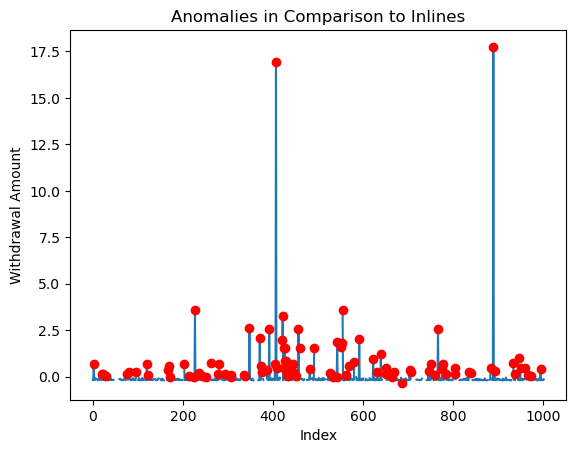

In [17]:
import matplotlib.pyplot as plt

# Plot the Withdrawal Amt. column
df["Withdrawal Amt."].plot()

# Plot the anomalous withdrawals
anomalous_withdrawals["Withdrawal Amt."].plot(style="ro")

# Set the plot title and labels
plt.title("Anomalies in Comparison to Inlines")
plt.xlabel("Index")
plt.ylabel("Withdrawal Amount")

# Show the plot
plt.show()


In [18]:
# show the anomalous entries in odf
adf1 = odf.iloc[anomalous_withdrawals.index]
adf1.sample(10)

,Date,Narration,Chq./Ref.No.,Value Dt,Withdrawal Amt.,Deposit Amt.
214,12/06/22,b'\xdb\xcf\xc0\x8e\xef\xda\xf9\xba\xf0\x1f\x9a...,0000216341852268,12/06/22,0.020771,NaN
632,26/12/22,b'\xd4q%\x08\xe8\xbf)\xf9\xe9\xc9l\x96\xc0\xac...,0000236088344349,26/12/22,0.032316,NaN
482,17/10/22,b'?\x89\xc9(\xa0p\x8a\xa9\x120\xdb\xbe\xa0cm\x...,0000229015578718,17/10/22,0.042778,NaN
434,27/09/22,"b'\xdcT\xa0\xb7B""\xeb\x9d\x11AfA\xad\x9c\xe9\x...",0000227067745044,27/09/22,0.021169,NaN
785,09/02/23,"b""j\x96\xb1V\xf7\xf0;{\xc8\x81\xdc\xd8D\x85\x1...",0000304041790396,09/02/23,0.025119,NaN
651,02/01/23,b':<\xa0\xedTk\xf3\xe5=?\x1b\x0e8\xa9<+\xc2\x8...,0000300215288187,02/01/23,0.045835,NaN
374,29/08/22,b'\x7f\x9d\xdb\xcc\xe7!\xc7\x95\xcf\x00$\x18\x...,0000224103670709,29/08/22,0.050392,NaN
21,04/04/22,b'3#\xa8\xdd\xc3Sx\x10\xe1\xa9\xcf;\x1c\xe5\x8...,0000209451164732,04/04/22,0.026847,NaN
77,23/04/22,b':<\xa0\xedTk\xf3\xe5=?\x1b\x0e8\xa9<+ \xecM\...,0000211318018419,23/04/22,0.026847,NaN
242,26/06/22,b'\xe4\xc0\x1a\x004\x8aW\xe3\xf5\xee\xaa\xcf\x...,0000217702172195,26/06/22,0.019916,NaN


In [19]:
odf.iloc[425]

Date                                                        24/09/22
Narration          b'\x8dh\x0f\x84^h\xbb:\xcd\x1d\xf6\x12vV\x89\x...
Chq./Ref.No.                                        0000226704574200
Value Dt                                                    24/09/22
Withdrawal Amt.                                             0.045873
Deposit Amt.                                                     NaN
Name: 425, dtype: object

In [20]:
# odf[odf["Narration"].str.decrypt_text.contains("AMEY")].head()

# decrypt the narration and check for contains
odf["Narration"] = odf["Narration"].apply(lambda x: decrypt_text(x, secret_key))


In [21]:
# use label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
odf["Narration_TF"] = le.fit_transform(odf["Narration"])
odf.iloc[[8, 33, 51, 52, 53]]

,Date,Narration,Chq./Ref.No.,Value Dt,Withdrawal Amt.,Deposit Amt.,Narration_TF
8,02/04/22,UPI-AMEY NITEEN WANI-AMEYWANI2012,0000209223765511,02/04/22,NaN,0.000616,33
33,11/04/22,UPI-AMEY NITEEN WANI-AMEYWANI2012,0000210122927068,11/04/22,NaN,0.000184,33
51,15/04/22,UPI-AMEY NITEEN WANI-AMEYWANI2012,0000210517003855,15/04/22,NaN,0.000936,33
52,15/04/22,UPI-AMEY NITEEN WANI-AMEYWANI2012,0000210517080933,15/04/22,NaN,0.000616,33
53,15/04/22,UPI-AMEY NITEEN WANI-AMEYWANI2012,0000210517069510,15/04/22,NaN,0.002216,33


In [22]:
odf.iloc[8]["Narration"] 

'UPI-AMEY NITEEN WANI-AMEYWANI2012'

In [23]:
odf.iloc[33]["Narration"]

'UPI-AMEY NITEEN WANI-AMEYWANI2012'

<Axes: >

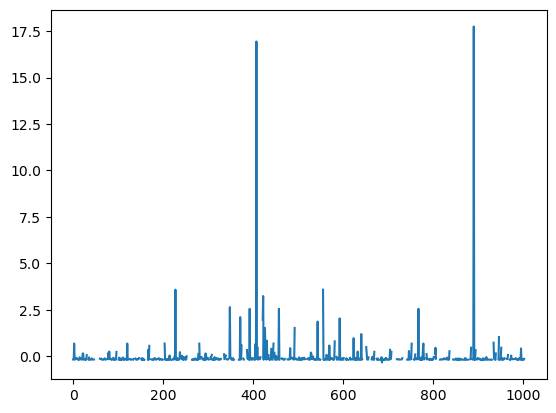

In [24]:
df["Withdrawal Amt."].plot()

<Axes: >

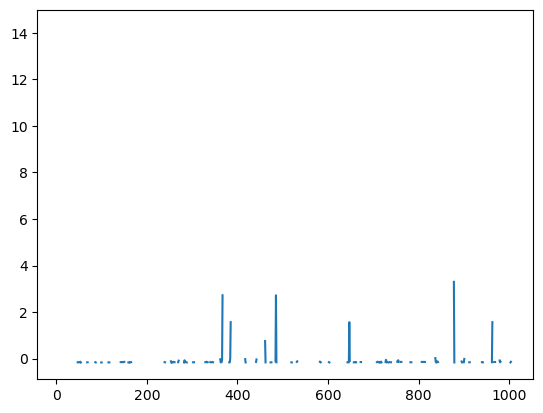

In [25]:
df["Deposit Amt."].plot()

In [26]:
from sklearn.ensemble import IsolationForest

# Create a dataframe with the columns of interest
# intc = "Withdrawal Amt."
intc = "Deposit Amt."

anomaly_df = odf[['Narration_TF', intc]]

# NaN values are not allowed, so we drop them
anomaly_df.dropna(inplace=True)

# Create an instance of the Isolation Forest model
model = IsolationForest(contamination=0.05, random_state=42)

# Fit the model to the data
model.fit(anomaly_df)

# Predict the anomalies
anomaly_pred = model.predict(anomaly_df)

# Add the anomaly predictions as a new column in the dataframe
anomaly_df['Anomaly'] = anomaly_pred

# Filter the dataframe to include only the anomalies
anomalies = anomaly_df[anomaly_df['Anomaly'] == -1]

# Print the anomalies
print(anomalies)


     Narration_TF  Deposit Amt.  Anomaly
200           318      0.391985       -1
205           321      0.000776       -1
230             5      1.000000       -1
340           322      0.001112       -1
354            18      0.159980       -1
367             3      0.199981       -1
385             1      0.119979       -1
461             8      0.063978       -1
485             4      0.199981       -1
493           262      0.039977       -1
552            13      0.042201       -1
647             0      0.119979       -1
878           312      0.239982       -1
963           169      0.119979       -1


C:\Users\Vedant\AppData\Local\Temp\ipykernel_96784\1460040516.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomaly_df.dropna(inplace=True)
c:\Users\Vedant\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Vedant\AppData\Local\Temp\ipykernel_96784\1460040516.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomaly_df['Anomaly'] = anomaly_pred


In [ ]:
odf.head()

In [28]:
def get_anomaly(intc):
    anomaly_df = odf[['Narration_TF', intc]]
    anomaly_df = anomaly_df.dropna()
    model = IsolationForest(contamination=0.05, random_state=42)
    model.fit(anomaly_df)
    anomaly_pred = model.predict(anomaly_df)
    anomaly_df['Anomaly'] = anomaly_pred
    anomalies = anomaly_df[anomaly_df['Anomaly'] == -1]
    return anomalies

In [29]:
def get_withdrawal_and_deposit_anomalies():
    withdrawal_anomalies = get_anomaly("Withdrawal Amt.")
    deposit_anomalies = get_anomaly("Deposit Amt.")
    return withdrawal_anomalies, deposit_anomalies

def get_net_expenditure():
    """Calculate the net expenditure over the entire dataset. But excule the anomalous entries"""
    """
    The net expenditure is calculated as the sum of the withdrawal amounts minus the sum of the deposit amounts.
    """
    withdrawal_anomalies, deposit_anomalies = get_withdrawal_and_deposit_anomalies()
    # drop the anomalous entries
    df1 = odf.drop(withdrawal_anomalies.index)
    df1 = df1.drop(deposit_anomalies.index)
    df1.head()
    # transform nan to 0
    df1["Withdrawal Amt."] = df1["Withdrawal Amt."].fillna(0)
    df1["Deposit Amt."] = df1["Deposit Amt."].fillna(0)
    net_expenditure = df1["Withdrawal Amt."].sum() - df1["Deposit Amt."].sum()
    return net_expenditure
    # net_expenditure = df["Withdrawal Amt."].sum() - df["Deposit Amt."].sum()
    # # Exclude the anomalous entries
    # net_expenditure -= withdrawal_anomalies["Withdrawal Amt."].sum()
    # net_expenditure += deposit_anomalies["Deposit Amt."].sum()


In [30]:
"""Calculate the net expenditure over the entire dataset. But excule the anomalous entries"""
"""
The net expenditure is calculated as the sum of the withdrawal amounts minus the sum of the deposit amounts.
"""
withdrawal_anomalies, deposit_anomalies = get_withdrawal_and_deposit_anomalies()
# drop the anomalous entries
df1 = odf.drop(withdrawal_anomalies.index)
df1 = df1.drop(deposit_anomalies.index)
df1.head()
# transform nan to 0
df1["Withdrawal Amt."] = df1["Withdrawal Amt."].fillna(0)
df1["Deposit Amt."] = df1["Deposit Amt."].fillna(0)
net_expenditure = df1["Withdrawal Amt."].sum() - df1["Deposit Amt."].sum()
net_expenditure

c:\Users\Vedant\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
c:\Users\Vedant\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


7.74264892771583

In [31]:
real_anomalies_withdraw = [407, 421, 422, 424, 426, 428, 430, 445, 460, 492, 543, 555, 592,  1000, 686, 767, 890, 934, 961]


In [ ]:
odf.iloc[real_anomalies_withdraw][["Date", "Narration", "Withdrawal Amt."]]

In [ ]:
withdrawal_anomalies
odf.iloc[withdrawal_anomalies.index][["Date", "Narration", "Withdrawal Amt."]]

In [34]:
not_real_anomalies_deposits = [205,340,461]
real_anomalies_deposits = deposit_anomalies.index.difference(not_real_anomalies_deposits)
real_anomalies_deposits


Index([200, 230, 354, 367, 385, 485, 493, 552, 647, 878, 963], dtype='int64')

In [ ]:
odf.iloc[real_anomalies_deposits][["Date", "Narration", "Deposit Amt."]]

In [ ]:
deposit_anomalies
odf.iloc[deposit_anomalies.index][["Date", "Narration", "Deposit Amt."]]

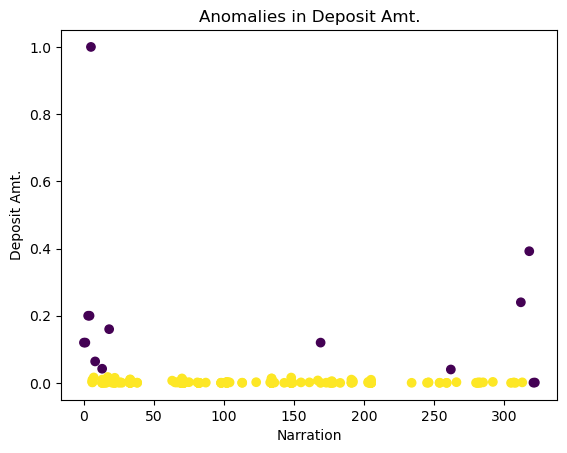

In [37]:
# visualize the anomalies
plt.scatter(anomaly_df['Narration_TF'], anomaly_df[intc], c=anomaly_df['Anomaly'])
plt.xlabel('Narration')
plt.ylabel(intc)
plt.title(f'Anomalies in {intc}')
plt.show()

In [38]:
from sklearn.ensemble import IsolationForest

# Create a dataframe with the columns of interest
# intc = "Withdrawal Amt."
intc = "Withdrawal Amt."

anomaly_df = odf[['Narration_TF', intc]]

# NaN values are not allowed, so we drop them
anomaly_df.dropna(inplace=True)

# Create an instance of the Isolation Forest model
model = IsolationForest(contamination=0.05, random_state=42)

# Fit the model to the data
model.fit(anomaly_df)

# Predict the anomalies
anomaly_pred = model.predict(anomaly_df)

# Add the anomaly predictions as a new column in the dataframe
anomaly_df['Anomaly'] = anomaly_pred

# Filter the dataframe to include only the anomalies
anomalies = anomaly_df[anomaly_df['Anomaly'] == -1]

# Print the anomalies
print(anomalies)


     Narration_TF  Withdrawal Amt.  Anomaly
123           293         0.023201       -1
227           134         0.216730       -1
262           293         0.058899       -1
280           250         0.056279       -1
348           190         0.164702       -1
371            50         0.134929       -1
376           306         0.031271       -1
392           323         0.159765       -1
407           109         0.955377       -1
421           224         0.127485       -1
422           135         0.197742       -1
424           131         0.102800       -1
426           260         0.102800       -1
428           169         0.064824       -1
430           158         0.064824       -1
445           251         0.056279       -1
457           323         0.159765       -1
460           262         0.102800       -1
492           131         0.102800       -1
543           244         0.121789       -1
551            50         0.108079       -1
553            50         0.1194

C:\Users\Vedant\AppData\Local\Temp\ipykernel_96784\3145424944.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomaly_df.dropna(inplace=True)
c:\Users\Vedant\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Vedant\AppData\Local\Temp\ipykernel_96784\3145424944.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomaly_df['Anomaly'] = anomaly_pred


In [39]:
import matplotlib.pyplot as plt

def visualize_anomalies(anomaly_df, intc, odf):
    plt.scatter(odf['Narration_TF'], odf[intc], c='blue')
    plt.scatter(anomaly_df['Narration_TF'], anomaly_df[intc], c=anomaly_df['Anomaly'])
    plt.xlabel('Narration')
    plt.ylabel(intc)
    plt.title(f'Anomalies in {intc}')
    plt.show()


c:\Users\Vedant\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
c:\Users\Vedant\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


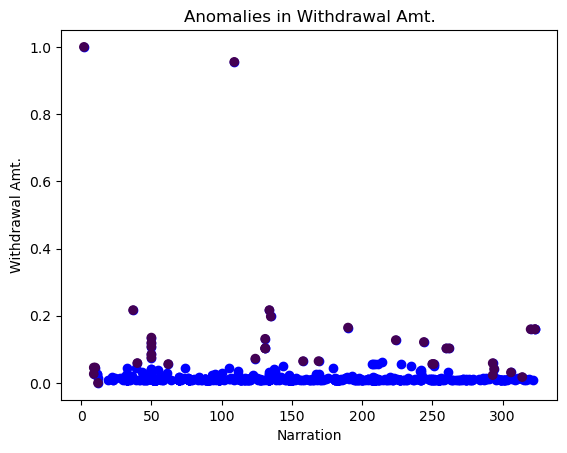

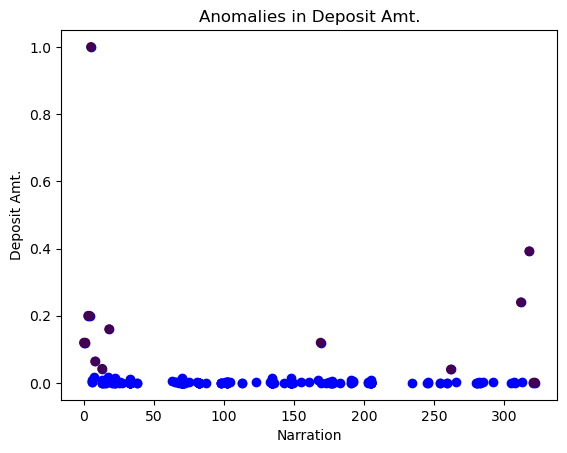

In [40]:
withdrawal_anomalies, deposit_anomalies = get_withdrawal_and_deposit_anomalies()

visualize_anomalies(withdrawal_anomalies, "Withdrawal Amt.", odf)
visualize_anomalies(deposit_anomalies, "Deposit Amt.", odf)
